# Data Preprocessing 
---

### 개요
* Data를 분석하기 위해서는 다음과 같은 조건이 필요함
    * Data 사이 분석을 위해 통일된 value 값의 크기  
        e.g.) 전력량 값과 온도 값 사이 비교/분석을 위해서는 서로 비슷한 크기로 data의 value 값을 조정해줘야 할 필요가 있음
    * 일정한 time_stamp 간격   
    
---    
* 아래 과정은 분석 전 data에 필요한 조건을 충족하기 위한 과정을 만족시키기 위한 **preprocessing 과정**임
<img src="https://raw.githubusercontent.com/jhyun0919/EnergyData_jhyun/master/docs/images/%EC%8A%A4%ED%81%AC%EB%A6%B0%EC%83%B7%202016-05-16%20%EC%98%A4%ED%9B%84%202.06.23.jpg" alt="Drawing" style="width: 800px;"/>

---
* 참고 )   
      배포한 모듈에 대한 변경사항이 있는 경우 반드시 다음 명령어를 실행하여 변경사항이 배포된 버전에 반영되도록 하자
```
>>> python setup.py sdist
>>> python setup.py install
```

---
* data-preprocessing 과정에 필요한 module들을 import 하자 

In [1]:
from utils import Preprocess
from utils import FileIO
from utils import GlobalParameter
from utils import Graph
%matplotlib inline
import os
import math

/Users/JH/Documents/GitHub/EnergyData_jhyun/energy_data_venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


---
* 모든 data file은 GlobalParameter.Repository_Path의 경로 아래에 저장하고 불러온다
* 다음 과정은 주어진 경로 아래에 저장된 특정 file을 지정하고 확인해보는 과정이다

In [2]:
file_path = os.path.join(GlobalParameter.Repository_Path, 'VTT')
file_name = 'VTT_GW1_HA10_VM_EP_KV_K.bin'
file_path = os.path.join(file_path, file_name)

file_path

'/Users/JH/Documents/GitHub/EnergyData_jhyun/repository/VTT/VTT_GW1_HA10_VM_EP_KV_K.bin'

---
* 해당 file의 data를 graph를 통해 확인해보자

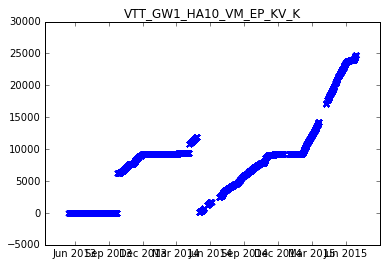

In [3]:
Graph.Show.bin2graph(file_path)

---
* 해당 file의 data를 직접 출력하여 확인해 보면 다음과 같은 문제점을 확인 가능하다
    * 일정하지 않은 ts
    * 정규화 되어있지 않은 value

In [4]:
data_dictionary = FileIO.Load.unpickling(file_path)

data_dictionary

{'file_name': 'VTT_GW1_HA10_VM_EP_KV_K',
 'ts': array([[datetime.datetime(2013, 5, 15, 10, 37, 23), 23, 37, ..., 2, 15, 5],
        [datetime.datetime(2013, 5, 15, 10, 42, 30), 30, 42, ..., 2, 15, 5],
        [datetime.datetime(2013, 5, 15, 10, 47, 30), 30, 47, ..., 2, 15, 5],
        ..., 
        [datetime.datetime(2015, 6, 30, 0, 46, 32), 32, 46, ..., 1, 30, 6],
        [datetime.datetime(2015, 6, 30, 0, 51, 32), 32, 51, ..., 1, 30, 6],
        [datetime.datetime(2015, 6, 30, 0, 56, 32), 32, 56, ..., 1, 30, 6]], dtype=object),
 'value': array([     0.,      0.,      0., ...,  24826.,  24826.,  24826.])}

##### graph를 통해 보면 문제가 없는 data로 보일 수 있지만, 직접 출력하여 확인하면 다음과 같은 문제점들을 가지고 있음
* 다른 file의 data 들과 통일되지 않은 value 값의 크기 ( **scaling** 필요 )
* 일정하지 않은 시간 간격 ( **normalization, interpolation** 필요 )

##### 이를 해결하기 위해 preprocessing 과정이 반드시 필요하다

---
### Step 01. Scaling

* 전처리의 첫 단계인 scaling을 실행해보자
* scaling을 통해 data의 모든 value값들이 절댓값 GlobalParameter.Scale_Size 사이 값으로 조정된다
* scaling의 크기는 GlobalParameter.Scale_Size에서 확인/변경 가능하다

In [5]:
# check scaling size
GlobalParameter.Scale_Size

100

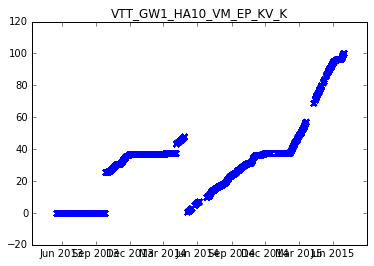

In [6]:
data_dictionary = Preprocess.scaling(data_dictionary)

Graph.Show.dic2graph(data_dictionary)

* 직접 출력하여 ts와 value 값을 보면 다음과 같은 문제점을 확인 가능하다
    * (**scaling** 통해 value 값은 정규화 되었음)
    * 시간의 간격이 일정하지 않음

In [7]:
data_dictionary

{'file_name': 'VTT_GW1_HA10_VM_EP_KV_K',
 'ts': array([[datetime.datetime(2013, 5, 15, 10, 37, 23), 23, 37, ..., 2, 15, 5],
        [datetime.datetime(2013, 5, 15, 10, 42, 30), 30, 42, ..., 2, 15, 5],
        [datetime.datetime(2013, 5, 15, 10, 47, 30), 30, 47, ..., 2, 15, 5],
        ..., 
        [datetime.datetime(2015, 6, 30, 0, 46, 32), 32, 46, ..., 1, 30, 6],
        [datetime.datetime(2015, 6, 30, 0, 51, 32), 32, 51, ..., 1, 30, 6],
        [datetime.datetime(2015, 6, 30, 0, 56, 32), 32, 56, ..., 1, 30, 6]], dtype=object),
 'value': array([   0.,    0.,    0., ...,  100.,  100.,  100.])}

---
### Step 02. Normalization

* 전처리의 두 번째 단계인 normalization을 실행해보자
* normalization을 통해 data의 모든 ts가 GlobalParameter.Normalization_Interval의 일정한 간격으로 조정된다
* 간격의 크기는 GlobalParameter.Normalization_Interval에서 확인/변경 가능하다

##### [ normalization strategy ]
* interval 사이의 값의 평균값을 해당 ts의 value 값으로 지정

* 아래는 GlobalParamter에서 지정된 Normalization_Interval을 보여주는 것이며 단위는 minute 이다

In [8]:
# check Normalization_Interval (minute)
GlobalParameter.Normalization_Interval

10

##### 일정한 간격으로 ts 값을 조정하다보면 해당 간격에 기록된 value 값이 없는 경우가 발생한다
* GlobalParameter.Normalization_Interval 사이 해당하는 value 값이 없으면 해당 값에 **NaN** 을 넣어주자

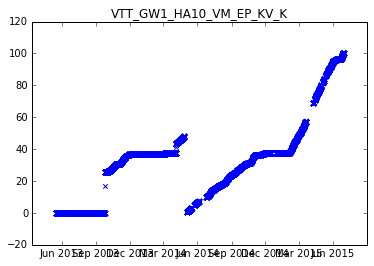

In [9]:
data_dictionary = Preprocess.normalization(data_dictionary)

Graph.Show.dic2graph(data_dictionary)

* 직접 출력하여 ts와 value 값을 보면 다음과 같은 문제점을 확인 가능하다
    * (**scaling** 통해 value 값은 정규화 되었음)
    * (**normalization** 통해 ts 값이 일정하게 조정 되었음)
    * **normalization** 과정에 **NaN**이 발생함

In [10]:
data_dictionary

{'file_name': 'VTT_GW1_HA10_VM_EP_KV_K',
 'ts': array([datetime.datetime(2013, 5, 15, 10, 30),
        datetime.datetime(2013, 5, 15, 10, 40),
        datetime.datetime(2013, 5, 15, 10, 50), ...,
        datetime.datetime(2015, 6, 30, 0, 30),
        datetime.datetime(2015, 6, 30, 0, 40),
        datetime.datetime(2015, 6, 30, 0, 50)], dtype=object),
 'value': array([   0.,    0.,    0., ...,  100.,  100.,  100.])}

* normalization 도중 발생한 NaN를 직접 확인

In [11]:
nancounter = 0

for line in data_dictionary['value']:
    if math.isnan(line):
        nancounter += 1
        
nancounter

17727

---
### Step 03. Interpolation
: normalization과정 발생한 NaN을 처리하기 위한 과정 

* 전처리의 마지막 단계인 interpolation을 실행해보자
* ts와 value가 1:1 매칭이 되도록 하기 위한 과정
* interpolation을 통해 기록된 값이 없는 경우(NaN)에 적절한 값을 배정하여 준다

##### [ interpolation strategy ]
* ts와 매칭되는 value가 NaN의 경우에, 앞/뒤 value의 평균값을 새로운 value로 배정
    * new_value  = avg(prev_value, next_value) 

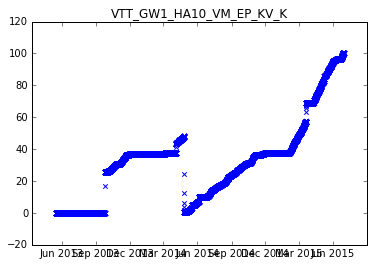

In [12]:
data_dictionary = Preprocess.interpolation(data_dictionary)

Graph.Show.dic2graph(data_dictionary)

In [13]:
data_dictionary

{'file_name': 'VTT_GW1_HA10_VM_EP_KV_K',
 'ts': array([datetime.datetime(2013, 5, 15, 10, 30),
        datetime.datetime(2013, 5, 15, 10, 40),
        datetime.datetime(2013, 5, 15, 10, 50), ...,
        datetime.datetime(2015, 6, 30, 0, 30),
        datetime.datetime(2015, 6, 30, 0, 40),
        datetime.datetime(2015, 6, 30, 0, 50)], dtype=object),
 'value': array([   0.,    0.,    0., ...,  100.,  100.,  100.])}

* interpolation 이후 NaN 제거 여부를 직접 확인

In [14]:
nancounter = 0

for line in data_dictionary['value']:
    if math.isnan(line):
        nancounter += 1
        
nancounter

0

* 다음의 문제점들이 모두 해결되었음을 확인
    * (**scaling** 통해 value 값은 정규화 되었음)
    * (**normalization** 통해 ts 값이 일정하게 조정 되었음)
    * (**interpolation**을 통해 NaN 제거)

---
##### 위 preprocessing 과정을 통해 아래와 같은 조건을 만족시켜 data를 분석하기 위한 준비과정을 완료하였음
* 일정한 크기로의 value 값을 조정 ( via **scaling** )
* 일정한 간격의 time_stamp ( via **normalization** ) 
* 모든 time_stamp에 value 값이 1:1 매칭 ( via **interpolation** )
